# **🏠 부동산 실거래가 Baseline based custom code (RandomForestRegressor)**     
> baseline 코드를 기반으로 수정된 아래의 custom code에서는 새로운 전처리 기법과 파생변수들을 통해 RandomForestRegressor를 대회에 적용해보도록 하겠습니다.

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save

## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [1]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
The following packages were automatically installed and are no longer required:
  fontconfig-config fonts-dejavu-core libatm1 libfontenc1 libjson-c4 liblmdb0
  libmaxminddb0 libmnl0 libxcb-shape0 libxcomposite1 libxinerama1 libxkbfile1
  libxtables12 libxtst6 libxv1 libxxf86dga1
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.


In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [3]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '../data/train.csv'
test_path  = '../data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [4]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [5]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(3))
display(dt_test.head(3))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.9700,202307,26,5,1987,...,직영,4858.00,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0
1,서울특별시 강남구 개포동,651-1,651.0,1.0,개포더샵트리에,108.2017,202308,15,10,2021,...,위탁,2724.46,305.0,의무,2022-02-23 13:01:10.0,Y,N,127.056394,37.484892,2022-02-23 11:05:05.0
2,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,161.0000,202307,28,15,1984,...,위탁,61064.24,419.0,의무,1984-12-22 00:00:00.0,Y,N,127.055990,37.483894,2013-03-07 09:46:28.0


## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [6]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [7]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [8]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})
concat = concat.rename(columns={'좌표X':'경도'})
concat = concat.rename(columns={'좌표Y':'위도'})

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


> 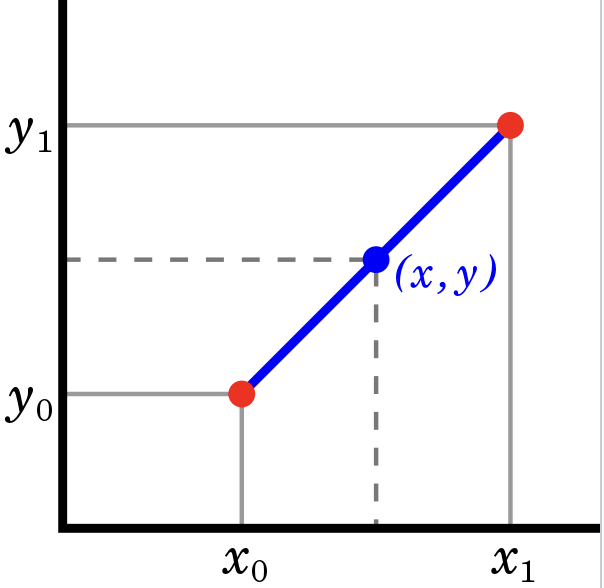

In [9]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들(' ', '-' 등)이 존재합니다.
# 그러한 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.

items = ['등기신청일자', '거래유형', '중개사소재지', 'k-사용검사일-사용승인일', 'k-등록일자', 'k-수정일자', '단지승인일', '단지신청일']

for item in items:
    concat[item] = concat[item].replace(' ', np.nan)
    concat[item] = concat[item].replace('-', np.nan)

- 보간 전, 외부 데이터를 활용해 결측치를 채워보겠습니다.
- 경도, 위도 결측치들을 Vworld Geocoder API 2.0를 통해 채워넣겠습니다.
- VWorld는 국토교통부의 공공 데이터 기반 국내 주소/POI(장소) 검색 서비스를 무료로 제공합니다.
- 자세한 내용은 [VWorld](https://www.vworld.kr/v4po_main.do)를 참고하세요.
- (주의! API 키는 보안상 개인이 직접 생성하여 사용하는 것으로 합니다.)

In [10]:
#먼저, 결측치가 몇 개나 되는지 확인해보겠습니다

(concat['경도'].isnull().sum(), concat['위도'].isnull().sum())

(876232, 876232)

In [15]:
# 우선, 이미 존재하는 값들을 토대로 결측치들을 채워넣을 수 있는 구조를 만들겠습니다
# 예를 들어, 어떤 거래 정보에 부동산의 좌표가 누락되어 있더라도,
# 같은 아파트의 다른 주소, 혹은 다른 날짜의 거래 정보에 해당 부동산의 좌표 정보가 포함되어 있다면
# 이를 바탕으로 누락된 정보들을 채워넣을 수 있게 됩니다

#set 자료형을 이용해 도로명 주소를 중복 없이 저장합니다
estate_address = set(concat['도로명'])

#도로명과 좌표를 연결할 dict 자료형을 생성합니다
estate_location = dict()
for address in estate_address:
    estate_location[address] = (np.nan, np.nan)

# 결측치를 검사할 함수를 작성합니다
def nolocation(x):
    return pd.isna(x[0]) or pd.isna(x[1])

# 가진 정보를 통해 dict를 채워넣습니다
for idx, row in concat.iterrows():
    if not nolocation(estate_location[row['도로명']]) or nolocation((row['경도'], row['위도'])):
        continue
    estate_location[row['도로명']] = (row['경도'], row['위도'])

# 채워지지 않은 dict 항목은 아래에서 VWorld API를 통해 채워주겠습니다

In [ ]:
# VWorld API를 통해 경도와 위도 정보의 결측치를 채워넣는 함수를 작성합니다
# VWorld는 기본적으로 무료로 제공되는 서비스이지만, 
# 서버에 큰 부하를 주지 않기 위해 이 함수는 최소한으로만 호출하는 것으로 합니다
# 특히, 초과사용 신청서를 작성하지 않은 기본 호출 제한은 일일 4만건임에 유의합니다
# (대회 제공 데이터셋의 경우, 아래의 과정을 거치면 최종적으로 8,411회 호출하게 됩니다)

import requests

def get_location_by_address(address, api_key):
    url = "https://api.vworld.kr/req/address?"

    params = {
        "service": "address", 
        "version": "2.0", 
        "request": "GetCoord", 
        "key": api_key, 
        "format": "json", 
        "type": "ROAD", 
        "address": address, 
        "refine": "true", 
        "simple": "false", 
        "crs": "epsg:4326"
    }
    
    res = requests.get(url, params=params)
    if res.status_code != 200:
        raise Exception(f"Request fails: {res.status_code}")
    
    data = res.json()
    results = data.get('response', {}).get('result', [])
    if not results:
        return (np.nan, np.nan)
    
    point = results['point']
    lng = float(point['x'])
    lat = float(point['y'])
    
    return (lng, lat)

In [17]:
# api key를 읽어옵니다
# 개인의 key는 반드시 보안화하여 보관하도록 합니다
my_api_key = open("../security/api-key.txt", 'r').read().strip()

In [18]:
# 작성한 함수를 토대로 dict를 채워넣습니다

for addr in estate_location:
    try: 
        if nolocation(estate_location[addr]):
            estate_location[addr] = get_location_by_address(addr, my_api_key)
    except:
        continue

# 주의! 인터넷 연결 상태 등에 따라 이 작업은 오래 걸릴 수 있습니다...

In [19]:
# 완성된 dict를 통해 결측치를 채워넣습니다

new_lng = concat['도로명'].apply(lambda x: estate_location[x][0])
new_lat = concat['도로명'].apply(lambda x: estate_location[x][1])

concat['경도'] = concat['경도'].fillna(new_lng)
concat['위도'] = concat['위도'].fillna(new_lat)

In [20]:
# 마지막으로, 이제 좌표 정보에 결측치가 얼마나 남아있는지 확인합니다
# 여전히 결측치가 남아있을 수 있지만, 꽤 많이 줄어들었을 것입니다

(concat['경도'].isnull().sum(), concat['위도'].isnull().sum())

(17703, 17703)

- 다음은 날짜 정보를 수정해주겠습니다.
- 현재 데이터 내 날짜는 yyyymmdd 형태의 int/float/str 자료형으로 흩어져 있습니다.
- 이러한 방식은 통일된 형식이 아닐 뿐더러 20101230, 20101231, 20110101 세 날짜에 대해, 똑같이 하루 차이지만 앞의 둘은 값이 1밖에 차이나지 않는데 반해 뒤의 둘은 값이 8870이나 차이나는 문제가 있습니다.
- 학습 데이터는 2007.01.01-2023.06.30.의 정보로 이루어져 있으므로, 1970.01.01을 0값으로 하고 이후 하루가 지날 때마다 1씩 증가한 값을 가지도록 변환해주겠습니다.
- int 자료형은 결측치를 지원하지 않으므로, 결측치가 없는 항목은 int, 있는 항목은 float로 통일하도록 하겠습니다.

In [21]:
# 1일 단위의 세부 날짜가 중요한 것은 아니므로 편의상 1년은 365일 고정, 1달은 30일 고정인 것으로 간주하겠습니다

# 먼저, string으로 된 날짜 데이터를 float로 변환해주는 함수를 작성합니다
def string_date_to_float(info):
    if type(info) != str:
        return np.nan
    yy, mm, dd = map(float, info.split(' ')[0].split('-')) # 시간(hh:mm) 정보까지는 필요 없으므로 제거합니다
    return (yy - 1970) * 365 + (mm - 1) * 30 + (dd - 1)

# 계약 날짜가 계약년월, 계약일로 나뉘어 있으므로 변환 후 하나로 통합해주겠습니다
concat['계약날짜'] = concat.apply(lambda row: ((row['계약년월'] // 100) - 1970) * 365 + (row['계약년월'] % 100 - 1) * 30 + (row['계약일'] - 1), axis=1)
concat = concat.drop(['계약년월', '계약일'], axis=1)

# 다음 날짜자료들도 변환해주겠습니다
# 자료형이 float, string 등으로 다양하므로 적절히 형변환을 거쳐 최종적으로 int 혹은 float가 되도록 하겠습니다
concat['해제사유발생일'] = concat.apply(lambda row: ((row['해제사유발생일'] // 10000) - 1970) * 365 + (row['해제사유발생일'] % 10000 // 100 - 1) * 30 + (row['해제사유발생일'] % 100 - 1), axis=1)
concat['등기신청일자'] = concat['등기신청일자'].astype(float)
concat['등기신청일자'] = concat.apply(lambda row: ((row['등기신청일자'] // 10000) - 1970) * 365 + (row['등기신청일자'] % 10000 // 100 - 1) * 30 + (row['등기신청일자'] % 100 - 1), axis=1)
concat['k-사용검사일-사용승인일'] = concat.apply(lambda row: string_date_to_float(row['k-사용검사일-사용승인일']), axis=1)
concat['k-등록일자'] = concat.apply(lambda row: string_date_to_float(row['k-등록일자']), axis=1)
concat['k-수정일자'] = concat.apply(lambda row: string_date_to_float(row['k-수정일자']), axis=1)
concat['단지승인일'] = concat.apply(lambda row: string_date_to_float(row['단지승인일']), axis=1)
concat['단지신청일'] = concat.apply(lambda row: string_date_to_float(row['단지신청일']), axis=1)

In [22]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적                   876170
k-관리비부과면적                  876125
k-전용면적별세대현황(60

In [23]:
display(concat.head(3))
display(concat.tail(3))

,시군구,번지,본번,부번,아파트명,전용면적,층,건축년도,도로명,해제사유발생일,...,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,경도,위도,단지신청일,target,is_test,계약날짜
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,3,1987,언주로 3,NaN,...,임의,19296.0,Y,N,127.05721,37.476763,19296.0,124000.0,0,17492
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,4,1987,언주로 3,NaN,...,임의,19296.0,Y,N,127.05721,37.476763,19296.0,123500.0,0,17506
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,5,1987,언주로 3,NaN,...,임의,19296.0,Y,N,127.05721,37.476763,19296.0,91500.0,0,17512


,시군구,번지,본번,부번,아파트명,전용면적,층,건축년도,도로명,해제사유발생일,...,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,경도,위도,단지신청일,target,is_test,계약날짜
9269,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,101.65,12,2014,신내역로1길 85,NaN,...,의무,16673.0,Y,N,127.10672,37.61887,16300.0,NaN,1,19581
9270,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.94,18,2014,신내역로1길 85,NaN,...,의무,16673.0,Y,N,127.10672,37.61887,16300.0,NaN,1,19586
9271,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.65,13,2014,신내역로1길 85,NaN,...,의무,16673.0,Y,N,127.10672,37.61887,16300.0,NaN,1,19588


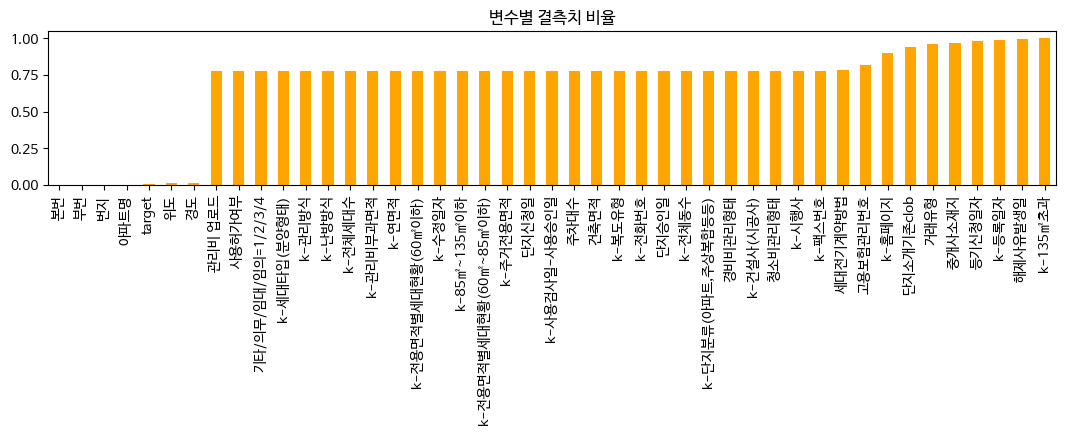

In [24]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

- 본 Custom code 에서는 결측치가 80% 이상인 칼럼이 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [25]:
# Null값이 80% 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 80% 미만인 변수들 :', list(concat.columns[concat.isnull().sum() < len(concat) * .8]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 80% 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= len(concat) * .8]))

* 결측치가 80% 미만인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '경도', '위도', '단지신청일', 'target', 'is_test', '계약날짜']
* 결측치가 80% 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', '고용보험관리번호']


In [26]:
# 위에서 결측치가 80% 미만인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() < len(concat) * .8])
concat_select = concat[selected]

In [27]:
concat_select.isnull().sum()     # 결측치가 80% 이상인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구                            0
번지                           227
본번                            75
부번                            75
아파트명                        2136
전용면적                           0
층                              0
건축년도                           0
도로명                            0
k-단지분류(아파트,주상복합등등)        877273
k-전화번호                    876850
k-팩스번호                    879348
k-세대타입(분양형태)              876125
k-관리방식                    876125
k-복도유형                    876454
k-난방방식                    876125
k-전체동수                    877207
k-전체세대수                   876125
k-건설사(시공사)                877637
k-시행사                     877834
k-사용검사일-사용승인일             876259
k-연면적                     876125
k-주거전용면적                  876170
k-관리비부과면적                 876125
k-전용면적별세대현황(60㎡이하)        876170
k-전용면적별세대현황(60㎡~85㎡이하)    876170
k-85㎡~135㎡이하              876170
k-수정일자                    876170
경비비관리형태                   877561
세대전기계약방법                  885389
청소비관리형태   

In [28]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 43 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   층                       1128094 non-null  int64  
 7   건축년도                    1128094 non-null  int64  
 8   도로명                     1128094 non-null  object 
 9   k-단지분류(아파트,주상복합등등)      250821 non-null   object 
 10  k-전화번호                  251244 non-null   object 
 11  k-팩스번호                  248746 non-null   object 
 12  k-세대타입(분양형태)            251969 non-null   object 
 13  k-관리방식                  251969 non-null   object 
 14  k-복도유

In [29]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [30]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '건축면적', '주차대수', '단지승인일', '경도', '위도', '단지신청일', 'target', 'is_test', '계약날짜']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '관리비 업로드']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [31]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [32]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구                       0
번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-전화번호                    0
k-팩스번호                    0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체동수                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-연면적                     0
k-주거전용면적                  0
k-관리비부과면적                 0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
k-수정일자                    0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
건축면적                      0
주차대수                      0
기타/의무/임대/임의=1/2/3/4       0
단지승인일                     0
사용허가여부              

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

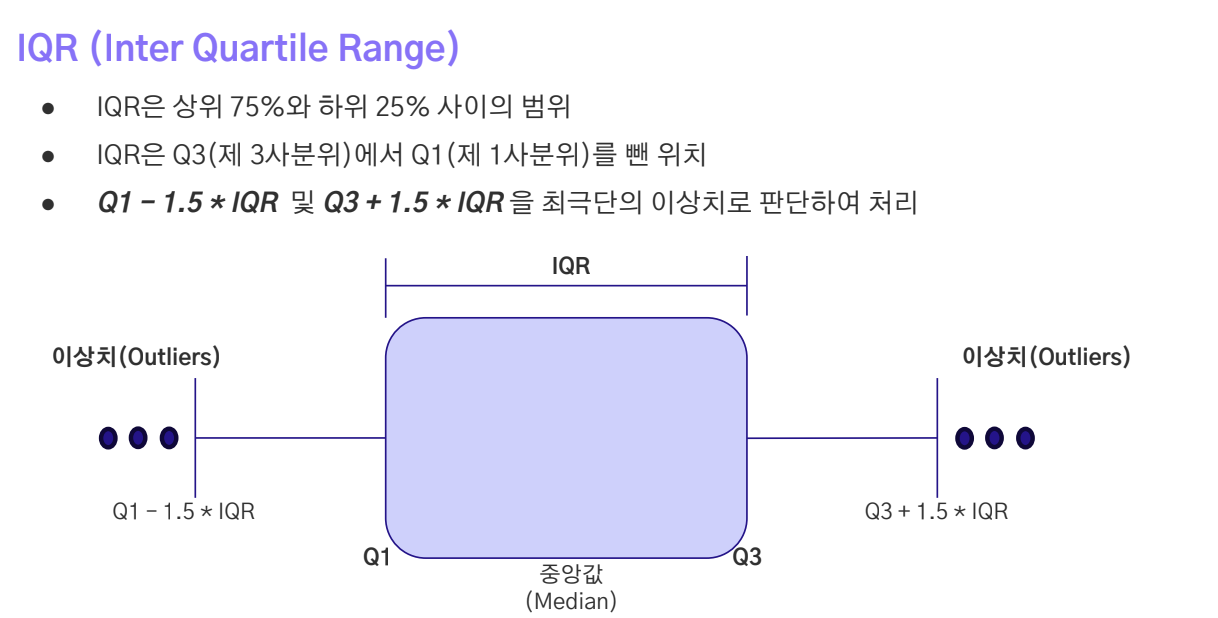

In [33]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 43)


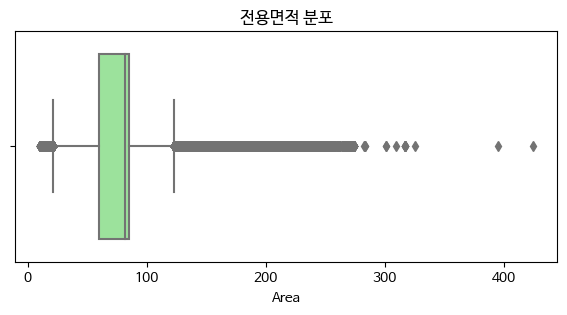

In [34]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [35]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [36]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat_select, '전용면적')

In [37]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1038846, 43)


In [38]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

0    1029574
1       9272
Name: is_test, dtype: int64

## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [39]:
# 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

In [40]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일',
       '사용허가여부', '관리비 업로드', '경도', '위도', '단지신청일', 'target', 'is_test', '계약날짜',
       '구', '동'],
      dtype='object')

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [41]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [42]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['강남여부'] = is_gangnam

In [43]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일',
       '사용허가여부', '관리비 업로드', '경도', '위도', '단지신청일', 'target', 'is_test', '계약날짜',
       '구', '동', '강남여부'],
      dtype='object')

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [44]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.038846e+06
mean     1.998583e+03
std      9.132471e+00
min      1.961000e+03
10%      1.987000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.009000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [45]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [46]:
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

,번지,본번,부번,아파트명,전용면적,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,...,경도,위도,단지신청일,target,is_test,계약날짜,구,동,강남여부,신축여부
0,658-1,658.0,1.0,개포6차우성,79.97,3,1987,언주로 3,아파트,025776611,...,127.05721,37.476763,19296.0,124000.0,0,17492,강남구,개포동,1,0


In [47]:
concat_select.shape

(1038846, 46)

- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

- 다음으로는 추가적인 파생 변수로 'c-한강인접도'와 'c-서울중심도'를 추가해보겠습니다.
- 먼저, 'c-한강인접도'는 한강 위 임의의 점들을 찍고 그 점들로부터의 거리(km)를 x라 할 때, 1/(x+1)²의 합으로 구하겠습니다.
- 구간은 김포대교~미사대교 구간으로 하고 1km 단위로 끊어 점들을 찍겠습니다.

In [74]:
# 먼저, 경도와 위도의 단위를 도(º)에서 km로 환산합니다
# 한국에서 경도 1도는 88.8km, 위도 1도는 111km로 변환됩니다

lng_std = 88.8
lat_std = 111

# 두 점의 경도와 위도 정보를 각각 입력받아 인접도를 계산하는 함수를 작성합니다
def proximity(p0, p1):
    x = (p0[0] - p1[0]) * lng_std
    y = (p0[1] - p1[1]) * lat_std
    dis = (x ** 2 + y ** 2) ** .5
    return 1 / (dis + 1) ** 2

In [91]:
concat_select['c-한강인접도'] = np.nan

# 한강 위 김포대교~미사대교 구간을 1km 단위로 끊은 좌표
Han_river_points = (
    (126.793203, 37.611399), 
    (126.802553, 37.606263), 
    (126.809983, 37.599605), 
    (126.818032, 37.593006), 
    (126.827079, 37.587918), 
    (126.836649, 37.582886), 
    (126.846158, 37.577979), 
    (126.855251, 37.572596), 
    (126.864558, 37.567350), 
    (126.873272, 37.561567), 
    (126.882504, 37.556451), 
    (126.891961, 37.551421), 
    (126.900664, 37.545681), 
    (126.909574, 37.540073), 
    (126.920345, 37.537403), 
    (126.930323, 37.533001), 
    (126.938621, 37.526906), 
    (126.947498, 37.521342), 
    (126.957798, 37.517523), 
    (126.967800, 37.513376), 
    (126.978538, 37.510455), 
    (126.989682, 37.512050), 
    (126.999353, 37.516762), 
    (127.007428, 37.523087), 
    (127.015395, 37.529530), 
    (127.022584, 37.536465), 
    (127.033810, 37.537409), 
    (127.044350, 37.533926), 
    (127.054882, 37.530639), 
    (127.064727, 37.526099), 
    (127.075242, 37.522969), 
    (127.086568, 37.523271), 
    (127.096553, 37.527582), 
    (127.104040, 37.534365), 
    (127.110369, 37.541772), 
    (127.115383, 37.549827), 
    (127.119528, 37.558189), 
    (127.126039, 37.565652), 
    (127.135999, 37.569934), 
    (127.147209, 37.571521), 
    (127.157087, 37.575875), 
    (127.166957, 37.580406), 
    (127.177249, 37.584182), 
    (127.187234, 37.588299), 
    (127.198362, 37.586260)
)

# c-한강인접도를 구합니다
concat_select['c-한강인접도'] = concat_select.apply(lambda row: sum(proximity((row['경도'], row['위도']), i) for i in Han_river_points), axis = 1)


- 다음은 'c-서울중심도'를 추가해보겠습니다.
- chatGPT의 추천에 따라, 서울의 중심을 강남역, 광화문, 삼성역, 서울역, 잠실역으로 정하고, 'c-서울중심도'는 마찬가지로 중심점으로부터의 거리(km)를 x라 할 때, 1/(x+1)²의 합으로 구하겠습니다.

In [92]:
concat_select['c-서울중심도'] = np.nan

# 각 중심점의 좌표
Gangnam_Station = (127.027613, 37.497951)
Gwanghwamun = (126.976809, 37.575871)
Samsung_Station = (127.063148, 37.508861)
Seoul_Station = (126.970825, 37.554047)
Jamsil_Station = (127.100133, 37.513261)
core_points = (
    Gangnam_Station, 
    Gwanghwamun, 
    Samsung_Station, 
    Seoul_Station, 
    Jamsil_Station
)

# c-서울중심도를 구합니다
concat_select['c-서울중심도'] = concat_select.apply(lambda row: sum(proximity((row['경도'], row['위도']), i) for i in core_points), axis = 1)

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [93]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1029574, 47) (9272, 47)


In [159]:
dt_test.sample(10)

,번지,본번,부번,아파트명,전용면적,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,...,위도,단지신청일,target,계약날짜,구,동,강남여부,신축여부,c-한강인접도,c-서울중심도
5596,1593-7,1593.0,7.0,서초이오빌,50.770,15,2003,효령로53길 45,주상복합,025862750,...,37.486602,15761.000000,13250.0,19542,서초구,서초동,1,0,0.546149,0.184293
2185,492,492.0,0.0,개봉푸르지오,119.980,13,2014,남부순환로 775,NULL,NULL,...,37.500452,16445.000000,13250.0,19569,구로구,개봉동,0,1,0.279973,0.017684
6411,239,239.0,0.0,정릉풍림아이원,59.880,9,2005,솔샘로 120,아파트,029195547,...,37.618589,15761.000000,13250.0,19595,성북구,정릉동,0,0,0.241031,0.050695
7791,1311,1311.0,0.0,동일하이빌2단지,84.955,3,2005,신정로11길 20,NULL,NULL,...,37.511960,17536.153025,13250.0,19543,양천구,신정동,0,0,0.303448,0.016854
6454,226,226.0,0.0,월곡래미안루나밸리,84.880,5,2007,월곡로14길 26,아파트,029426977,...,37.599088,15761.000000,13250.0,19539,성북구,하월곡동,0,0,0.325815,0.052439
1644,1694,1694.0,0.0,신림현대,34.860,14,1993,신림로29길 8,아파트,028757446,...,37.474937,15761.000000,13250.0,19587,관악구,신림동,0,0,0.357355,0.034986
6443,222,222.0,0.0,월곡두산위브,114.752,11,2003,오패산로 46,아파트,0262295755,...,37.607034,15761.000000,13250.0,19565,성북구,하월곡동,0,0,0.288683,0.047974
7775,520-8,520.0,8.0,태산,51.640,7,2015,오목로 20,NULL,NULL,...,37.290251,17600.266904,13250.0,19575,양천구,신월동,0,1,0.041398,0.004974
2589,692,692.0,0.0,디큐브시티,84.960,21,2011,경인로 662,NULL,NULL,...,37.508134,19235.934394,13250.0,19585,구로구,신도림동,0,1,0.476167,0.028962
3071,721,721.0,0.0,상계주공5,31.980,3,1987,동일로216길 47,NULL,NULL,...,37.652761,15761.000000,13250.0,19575,노원구,상계동,0,0,0.168541,0.020808


In [160]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

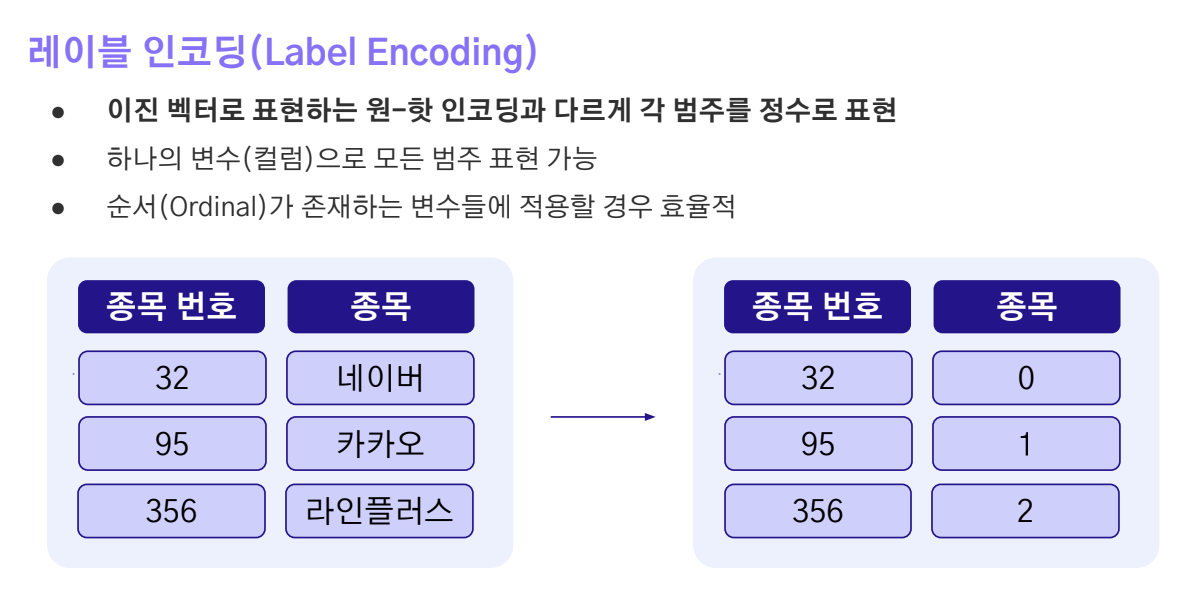

In [161]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '건축면적', '주차대수', '단지승인일', '경도', '위도', '단지신청일', 'target', '계약날짜', '강남여부', '신축여부', 'c-한강인접도', 'c-서울중심도']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '관리비 업로드', '구', '동']


In [162]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 22/22 [00:05<00:00,  3.88it/s]


In [163]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,번지,본번,부번,아파트명,전용면적,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,...,위도,단지신청일,target,계약날짜,구,동,강남여부,신축여부,c-한강인접도,c-서울중심도
0,4282,1114,1,293,79.97,3,1987,5520,3,456,...,37.476763,19296.0,124000.0,17492,0,8,1,0,0.379325,0.130654


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 RandomForest를 이용하겠습니다.
- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
  - 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

In [164]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [165]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [166]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

- 랜덤포레스트의 하이퍼파라미터도 데이터에 맞게 지정해줄 수 있습니다. 데이터에 맞는 하이퍼파라미터를 찾는 것도 성능 향상에 도움이 될 수 있습니다.

In [187]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 5303.498519555464


- 변수 중요도도 확인해보도록 하겠습니다.

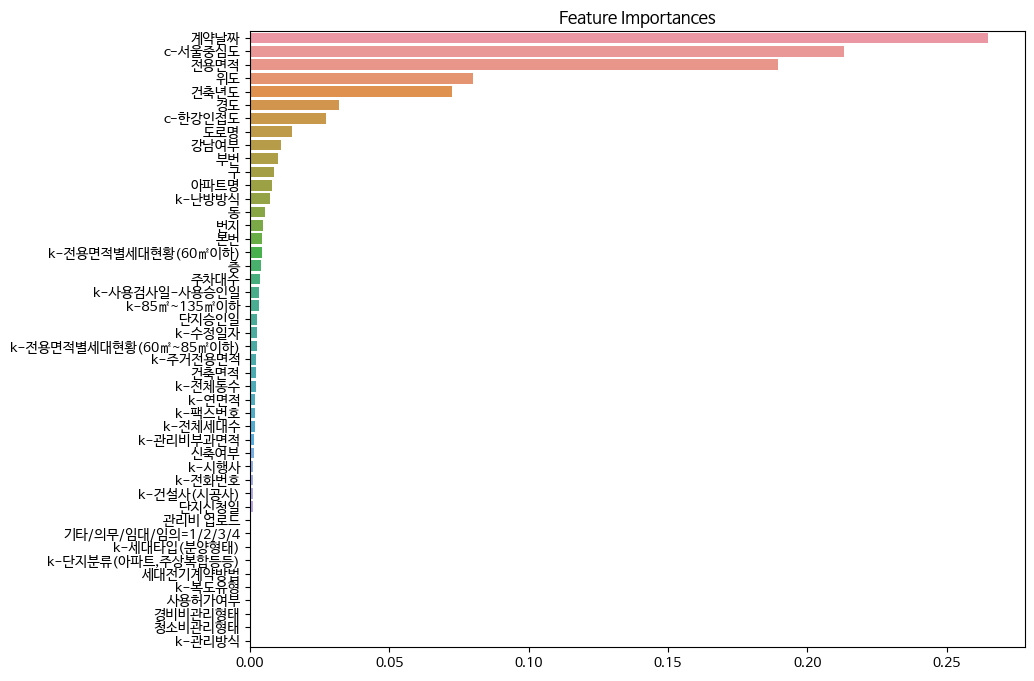

In [168]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [169]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('../model/saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [170]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
911251040.9803 ± 6298669.9658,계약날짜
493256813.2090 ± 3786936.2669,전용면적
489937044.5638 ± 8124439.3167,c-서울중심도
362631170.1073 ± 3713556.6396,위도
221054067.7940 ± 2339745.9605,건축년도
116006609.1953 ± 1368810.2331,c-한강인접도
96855389.7854 ± 1401860.1018,강남여부
89175268.2533 ± 1093554.2425,경도
60181854.0088 ± 174212.6720,도로명
34468507.2827 ± 815280.9820,부번


- 분석 결과 "계약날짜", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [171]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [172]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [173]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [174]:
X_val_sort.head()

,번지,본번,부번,아파트명,전용면적,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,...,계약날짜,구,동,강남여부,신축여부,c-한강인접도,c-서울중심도,target,pred,error
224608,4125,1074,258,4766,91.68,3,2017,2220,0,1049,...,19156,0,281,1,1,1.374573,0.219743,117562.0,294600.0,3.134245e+10
239612,1496,554,214,1523,84.99,15,2021,0,0,1049,...,18815,0,137,1,1,0.648400,0.449372,328000.0,174100.0,2.368521e+10
232753,4866,1223,0,2080,107.47,1,1973,5026,0,1049,...,18990,14,111,1,0,1.122002,0.205639,287000.0,425000.0,1.904400e+10
233410,4277,1112,221,3432,68.66,2,1983,6109,0,1049,...,19075,15,156,0,0,0.997780,0.103790,227000.0,96600.0,1.700416e+10
239630,3365,890,86,2455,115.89,2,2003,3716,0,1049,...,18733,0,137,1,0,0.982654,0.318112,75000.0,198800.0,1.532644e+10


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [175]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [176]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [177]:
display(error_top100.head(10))
display(best_top100.head(10))

,번지,본번,부번,아파트명,전용면적,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,...,계약날짜,구,동,강남여부,신축여부,c-한강인접도,c-서울중심도,target,pred,error
224608,62-6,62.0,6.0,청담디에브스,91.6800,3,2017,도산대로92길 28,NULL,NULL,...,19156,강남구,청담동,1,1,1.374573,0.219743,117562.0,294600.0,3.134245e+10
239612,19-4,19.0,4.0,래미안라클래시,84.9900,15,2021,,NULL,NULL,...,18815,강남구,삼성동,1,1,0.648400,0.449372,328000.0,174100.0,2.368521e+10
232753,757,757.0,0.0,반포주공1단지,107.4700,1,1973,신반포로 45,NULL,NULL,...,18990,서초구,반포동,1,0,1.122002,0.205639,287000.0,425000.0,1.904400e+10
233410,656-421,656.0,421.0,신장미,68.6600,2,1983,왕십리로 66-15,NULL,NULL,...,19075,성동구,성수동1가,0,0,0.997780,0.103790,227000.0,96600.0,1.700416e+10
239630,47-18,47.0,18.0,삼성동드림하우스,115.8900,2,2003,봉은사로71길 19,NULL,NULL,...,18733,강남구,삼성동,1,0,0.982654,0.318112,75000.0,198800.0,1.532644e+10
274602,157,157.0,0.0,동아,84.9100,1,2002,신반포로33길 15,NULL,NULL,...,18844,서초구,잠원동,1,0,1.141332,0.184398,104500.0,225000.0,1.452025e+10
58002,12,12.0,0.0,한신15차,122.1000,2,1982,신반포로15길 5,NULL,NULL,...,17589,서초구,반포동,1,0,0.998140,0.128143,350000.0,231300.0,1.408969e+10
423713,159,159.0,0.0,아크로리버뷰신반포,78.5000,8,2018,잠원로 117,NULL,NULL,...,17932,서초구,잠원동,1,1,1.482458,0.154338,109258.0,227200.0,1.391032e+10
1063068,27,27.0,0.0,주공,82.6100,12,1978,송파대로 567,NULL,NULL,...,13858,송파구,잠실동,1,0,1.169895,0.446733,24000.0,140600.0,1.359556e+10
291001,176-1,176.0,1.0,서울역센트럴자이,39.9541,2,2017,만리재로,아파트,023629951,...,18610,중구,만리동2가,0,1,0.648400,0.449372,161000.0,45303.4,1.338570e+10


,번지,본번,부번,아파트명,전용면적,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,...,계약날짜,구,동,강남여부,신축여부,c-한강인접도,c-서울중심도,target,pred,error
175563,1344,1344.0,0.0,방배1차현대홈타운,84.96,2,1999,서초대로1길 30,NULL,NULL,...,14349,서초구,방배동,1,0,0.673692,0.084795,71000.0,71000.0,0.0
673694,453-1,453.0,1.0,삼성광장2,69.06,1,1989,아차산로 544,NULL,NULL,...,16349,광진구,광장동,0,0,1.582172,0.108667,40000.0,40000.0,0.0
203229,746,746.0,0.0,까치마을,34.44,3,1993,광평로19길 10,NULL,NULL,...,19511,강남구,수서동,1,0,0.404412,0.133607,82000.0,82000.0,0.0
978598,1267,1267.0,0.0,신도림태영타운,59.88,11,2000,새말로 93,아파트,028666365,...,14562,구로구,구로동,0,0,0.458628,0.028681,35000.0,35000.0,0.0
798561,59,59.0,0.0,한양2,76.92,5,1988,해등로 231,NULL,NULL,...,16151,도봉구,쌍문동,0,0,0.159133,0.022826,24000.0,24000.0,0.0
93859,142-1,142.0,1.0,위더스하임,23.82,6,2018,퇴계로73길 20,NULL,NULL,...,17549,중구,흥인동,0,1,0.562930,0.123688,29800.0,29800.0,0.0
214236,673,673.0,0.0,강일리버파크4단지,84.83,7,2009,아리수로97길 19,아파트,024288585,...,14372,강동구,강일동,1,1,0.844552,0.025104,35340.0,35340.0,0.0
1088603,1141,1141.0,0.0,서초파레스,79.70,2,2005,시흥대로128길 19,NULL,NULL,...,13655,금천구,독산동,0,0,0.266593,0.024050,20000.0,20000.0,0.0
313318,1708,1708.0,0.0,두산,59.92,2,2000,봉천로 387,NULL,NULL,...,18159,관악구,봉천동,0,0,0.468121,0.043513,62000.0,62000.0,0.0
429073,11-4,11.0,4.0,잠실푸르지오월드마크,108.32,17,2013,올림픽로35가길 9,주상복합,024218700,...,18061,송파구,신천동,1,1,1.011061,0.483003,135000.0,135000.0,0.0


- 이제 분포를 비교해보도록 하겠습니다.

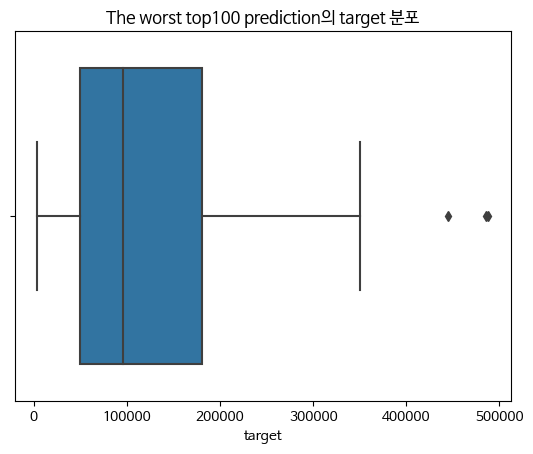

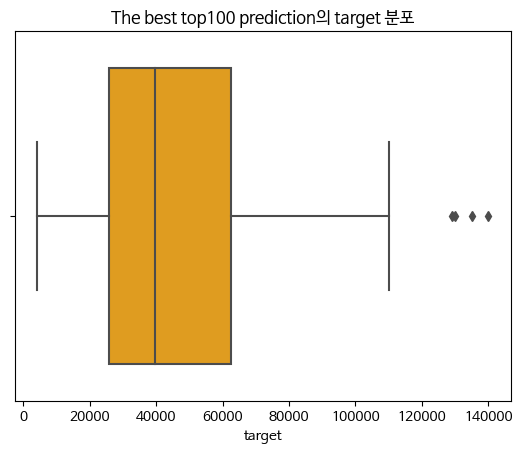

In [178]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

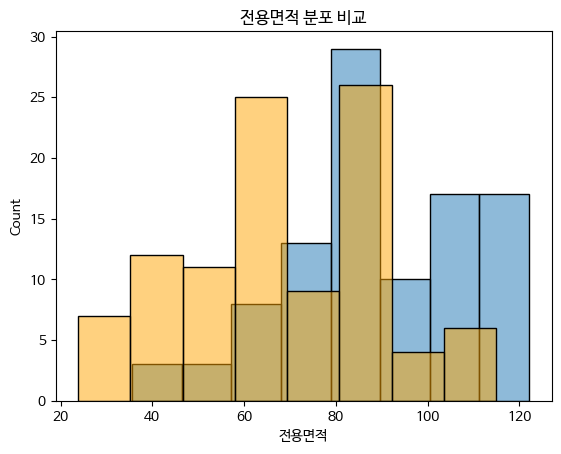

In [179]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [180]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,번지,본번,부번,아파트명,전용면적,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,...,위도,단지신청일,target,계약날짜,구,동,강남여부,신축여부,c-한강인접도,c-서울중심도
0,4282,1114,1,293,79.9700,5,1987,5520,3,456,...,37.476763,19296.0,0,19550,0,8,1,0,0.379325,0.130654
1,4258,1107,1,294,108.2017,10,2021,431,3,451,...,37.484892,19032.0,0,19569,0,8,1,1,0.452246,0.177044


In [181]:
# 저장된 모델을 불러옵니다.
with open('../model/saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [182]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 25.7 ms, sys: 0 ns, total: 25.7 ms
Wall time: 19.3 ms


In [183]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([223200., 257600., 290000., ...,  86200.,  69800.,  67100.])

## 7. Output File Save

In [184]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('../result/output.csv', index=False)

In [185]:
display(preds_df)

,target
0,223200
1,257600
2,290000
3,290000
4,217600
...,...
9267,67100
9268,67100
9269,86200
9270,69800


In [ ]:
# 추가로, 전처리된 학습 데이터를 저장할 수 있습니다.
# 이 데이터를 concat_select라는 이름으로 불러온 후 "5챕터: Model Training"부터 진행할 수 있습니다.

concat_select.to_csv('../data/concat_selected.csv')